Follow the Guidances for Each Topic
1. Do exploratory data analysis.
2. Select features with reasonable tools.
3. Do data pre-processing Pipeline.
4. Build customed neural network with reasonable number of hidden layers and number of neu-
rons in each layer, or exising neural network model to predict target provided in individual
topic.

    - Using TensorFlow

1. House Sales in King County, USA
Objective:
-  predict house price
    - Dataset:
            https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data
    - Article: https://cran.r-project.org/web/packages/KingCountyHouses/KingCountyHouses.pdf

2. Dry Bean
- Objective:
classify dry bean class

- Dataset: https://archive.ics.uci.edu/dataset/602/dry+bean+dataset
- Article: https://ceur-ws.org/Vol-2951/paper3.pdf

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'kc_house_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


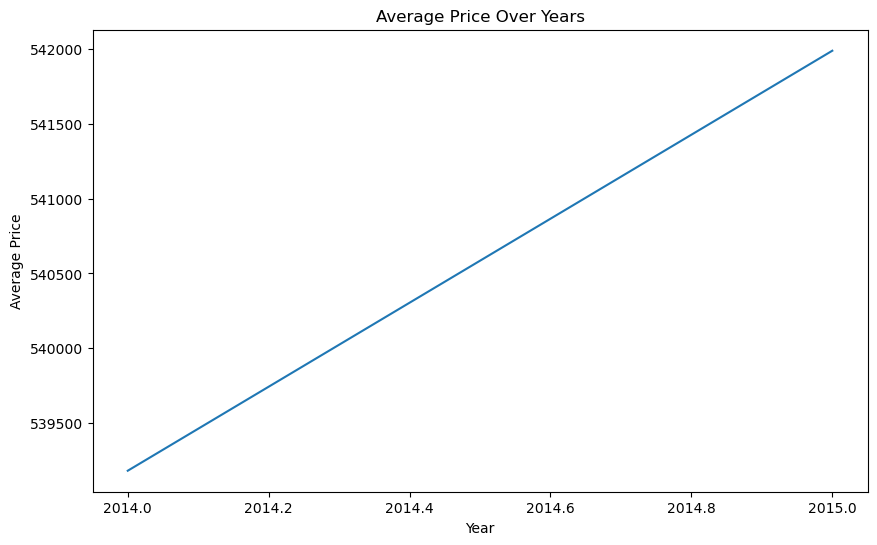

In [5]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')  # Coerce invalid values to NaT

# Extract the year from the 'date' column
df['year'] = df['date'].dt.year

# Analyze price trends over years
avg_price_per_year = df.groupby('year')['price'].mean()
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_price_per_year.index, y=avg_price_per_year.values)
plt.title("Average Price Over Years")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.show()

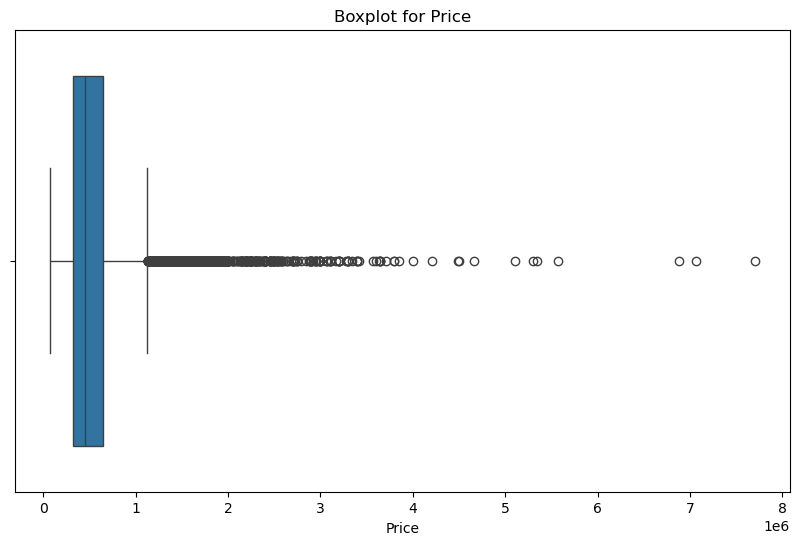

In [6]:
# Boxplot for Price
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price'])
plt.title("Boxplot for Price")
plt.xlabel("Price")
plt.show()

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
yr_renovated     0.126434
sqft_lot         0.089661
sqft_lot15       0.082447
yr_built         0.054012
condition        0.036362
long             0.021626
year             0.003576
date            -0.004357
id              -0.016762
zipcode         -0.053203
Name: price, dtype: float64


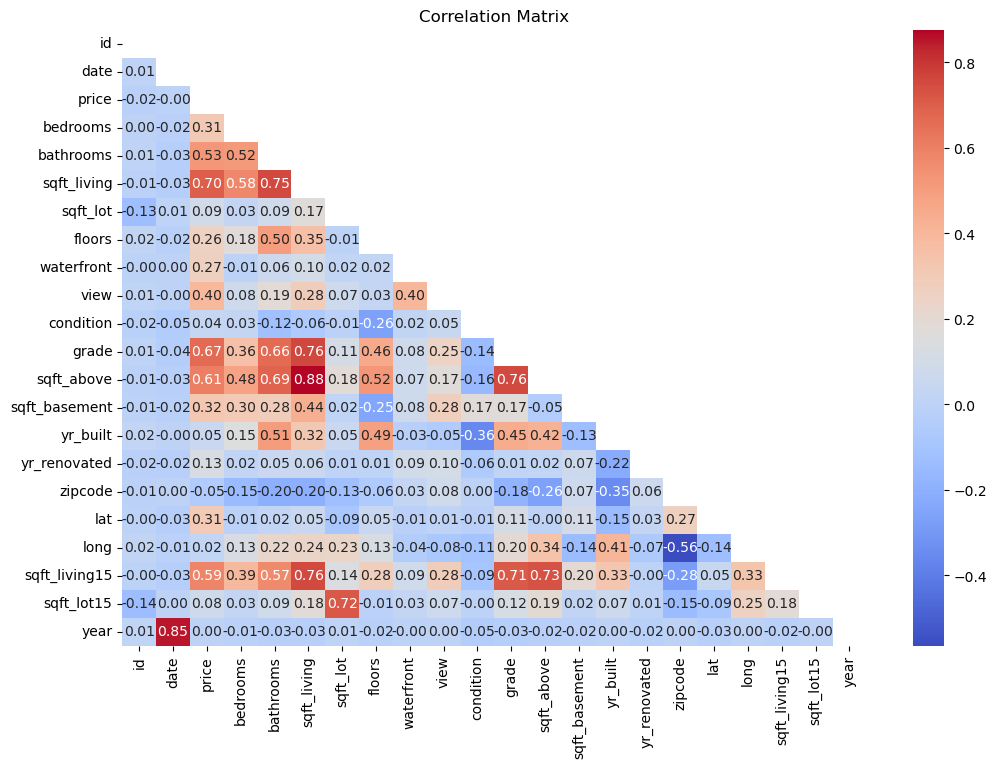

In [7]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation = df.corr()

# Display correlation with 'price'
print(correlation['price'].sort_values(ascending=False))

# Visualize the correlation matrix
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(correlation))
plt.title("Correlation Matrix")
plt.show()

In [8]:
# Define target column and categories
target = 'price'
yes_no_columns = []
cat_columns = []
num_columns = []
columns_to_drop = ['date','id', 'zipcode', 'long', 'year', 'condition', 'yr_built', 'sqft_lot', 'sqft_lot15']

# Classify columns
for column in df.columns:
    if column == target:
        continue
    elif column in columns_to_drop:
        continue
    elif df[column].nunique() == 2:  # Check if the column has exactly 2 unique values
        yes_no_columns.append(column)
    elif df[column].nunique() <= 4:  # Check if the column has 4 or fewer unique values
        cat_columns.append(column)
    else:
        num_columns.append(column)

# Print the results
print("Yes/No Columns:", yes_no_columns)
print("Categorical Columns:", cat_columns)
print("Numerical Columns:", num_columns)

Yes/No Columns: ['waterfront']
Categorical Columns: []
Numerical Columns: ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'sqft_basement', 'yr_renovated', 'lat', 'sqft_living15']


In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer

# Numeric pipeline: Impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())                
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing with mode
    ('encoder', OneHotEncoder())    # One-hot encode categories
])
yes_no_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Replace missing with mode
    ('Ordinal', OrdinalEncoder())    # Ordinal categories
])

In [10]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_columns),
    ('cat', categorical_transformer, cat_columns),
    ('yes_no',yes_no_transformer,yes_no_columns)
])

In [11]:
def drop_columns(X):
    return X.drop(columns =columns_to_drop)

In [12]:
x=df.drop(columns=target)
y=df[target]
X_transformed = preprocessor.fit_transform(x)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


# The Decision Tree model

In [15]:
# Import necessary libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Define your callback (example)
class TrainingCompleteCallback:
    def on_train_end(self):
        print("Training process completed!")

# Initialize and train the Decision Tree model
model_dt = DecisionTreeRegressor(random_state=42)
model_dt.fit(X_train, y_train)

# Make predictions
y_pred1 = model_dt.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred1)
mse = mean_squared_error(y_test, y_pred1)
rmse = np.sqrt(mse)
score=r2_score(y_test, y_pred1)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {score}')

Mean Absolute Error: 123425.69191919193
Mean Squared Error: 56045751541.86677
Root Mean Squared Error: 236739.8393635232
R² Score: 0.6292699404214962


# Random Forests Model

In [16]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the Random Forest model
model_rfm = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfm.fit(X_train, y_train)

# Make predictions
y_pred2 = model_rfm.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred2)
mse = mean_squared_error(y_test, y_pred2)
rmse = np.sqrt(mse)
score=r2_score(y_test, y_pred1)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {score}')

Mean Absolute Error: 90289.63875708009
Mean Squared Error: 32481538759.76668
Root Mean Squared Error: 180226.35423202312
R² Score: 0.6292699404214962


 # The neural network model

In [17]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define your callback (example)
class TrainingCompleteCallback(Callback):
    def on_train_end(self, logs=None):
        print("Training process completed!")

# Define the model
model_nnm = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(8, activation="relu"),
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model_nnm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model
model_nnm.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[TrainingCompleteCallback()])

# Make predictions
y_pred3 = model_nnm.predict(X_test).flatten()  # Flatten the predictions to match the shape of y_true

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred3)
mse = mean_squared_error(y_test, y_pred3)
rmse = np.sqrt(mse)
score = r2_score(y_test, y_pred3)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {score}')

Epoch 1/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 208286892032.0000 - mae: 326313.9688 - val_loss: 52188225536.0000 - val_mae: 134803.1562
Epoch 2/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 45450272768.0000 - mae: 132541.3125 - val_loss: 50118328320.0000 - val_mae: 142183.0781
Epoch 3/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 42332987392.0000 - mae: 127029.2891 - val_loss: 46101139456.0000 - val_mae: 127184.9922
Epoch 4/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 39119454208.0000 - mae: 124241.5781 - val_loss: 47277547520.0000 - val_mae: 125190.5312
Epoch 5/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 41117323264.0000 - mae: 123997.7969 - val_loss: 45569302528.0000 - val_mae: 124081.9844
Epoch 6/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 40318894080.0000 - mae: 123698.8750 - val_loss: 44962574336.0000 - val_mae: 126595.8750
Epoch 7/50
541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 36326211584.0000 - mae: 119986.8125 - val_loss: 487

# Support Vector Machines (SVM)

In [18]:
# Import necessary libraries
from sklearn.svm import SVR

# Initialize and train the SVR model
model_svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model_svr.fit(X_train, y_train)

# Make predictions
y_pred4 = model_svr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred4)
mse = mean_squared_error(y_test, y_pred4)
rmse = np.sqrt(mse)
score = r2_score(y_test, y_pred4)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {score}')

Mean Absolute Error: 185851.839008032
Mean Squared Error: 135562439404.40482
Root Mean Squared Error: 368188.04897009465
R² Score: 0.1032849082332361
